## Import dependencies

In [1]:
import numpy as np
import sys
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sn
import glob

sys.path.append('../../')
from FaIRv2_0_0_alpha import *
from scripts.data_retrieval import *
from scripts.stats import *
from scripts.FaIR_tuning_scripts import *

%matplotlib inline

# I. Gas cycle parameters

### data retrieval

#### concentrations

WMGHG concentrations are from the CMIP6 concentration dataset, [Meinshausen et al., 2017](https://www.geosci-model-dev.net/10/2057/2017/). For some species, these are extended using data from NOAA.

Reference:

Meinshausen, M., Vogel, E., Nauels, A., Lorbacher, K., Meinshausen, N., Etheridge, D. M., … Weiss, R. (2017). Historical greenhouse gas concentrations for climate modelling (CMIP6). Geoscientific Model Development, 10(5), 2057–2116. https://doi.org/10.5194/gmd-10-2057-2017

In [2]:
import ftplib

## import concentrations from official CMIP6 timeseries:
CMIP6_conc_ftp = ftplib.FTP('data.iac.ethz.ch','anonymous')
CMIP6_conc_ftp.cwd('CMIP6/input4MIPs/UoM/GHGConc/CMIP/yr/atmos/UoM-CMIP-1-1-0/GHGConc/gr3-GMNHSH/v20160701')
CMIP6_ftp_list = [x for x in CMIP6_conc_ftp.nlst() if x[-3:]=='csv']
WMGHG_concs = pd.DataFrame(dict(zip(['_'.join(x.split('_')[3:-8]) for x in CMIP6_ftp_list],[pd.read_csv('ftp://data.iac.ethz.ch/CMIP6/input4MIPs/UoM/GHGConc/CMIP/yr/atmos/UoM-CMIP-1-1-0/GHGConc/gr3-GMNHSH/v20160701/'+x,usecols=[0,1],index_col=0).iloc[:,0] for x in CMIP6_ftp_list])))
WMGHG_concs = WMGHG_concs[[x for x in WMGHG_concs.columns if x[-2:]!='eq']] # remove "equivalent" concentrations

WMGHG_concs['halon1202'] = 0
WMGHG_concs.loc[1765:2014,'halon1202'] = pd.read_csv('http://www.pik-potsdam.de/~mmalte/rcps/data/RCP45_MIDYEAR_CONCENTRATIONS.DAT',skiprows=38,delim_whitespace=True,index_col=0)['HALON1202'].loc[1765:2014].values

In [3]:
## we extend CO2, CH4 & N2O out to 2019 using the NOAA ESRL data
NOAA_molefrac = pd.read_csv('https://www.esrl.noaa.gov/gmd/aggi/NOAA_MoleFractions_2020.csv',skiprows=2,index_col=0,skipfooter=5).iloc[1:].replace('nd',np.nan).apply(pd.to_numeric).rename(dict(CO2='carbon_dioxide',CH4='methane',N2O='nitrous_oxide'),axis=1)

WMGHG_concs = WMGHG_concs.reindex(np.arange(2020))

for species in ['carbon_dioxide','methane','nitrous_oxide']:
    
    # scale the NOAA data to join seamlessly (scale factors are almost exactly 1)
    scale_factor = WMGHG_concs.loc[2010:2014,species].mean() / NOAA_molefrac.loc[2010:2015,species].mean()
    WMGHG_concs.loc[2015:2019,species] = NOAA_molefrac.loc[2015:2020,species].values * scale_factor

/home/leachl/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  


In [4]:
WMGHG_concs.drop(np.arange(1750),inplace=True)

In [5]:
# rescale all GHGs to be in ppb (bar CO2)
WMGHG_concs[WMGHG_concs.columns.drop(['carbon_dioxide','methane','nitrous_oxide'])] *= 1/1000

#### emissions

Emissions are taken from the RCMIP protocol.

Reference:

Nicholls, Z. R. J., Meinshausen, M., Lewis, J., Gieseke, R., Dommenget, D., Dorheim, K., … Xie, Z. (2020). Reduced complexity model intercomparison project phase 1: Protocol, results and initial observations. Geoscientific Model Development Discussions, 1–33. https://doi.org/10.5194/gmd-2019-375

In [6]:
RCMIP_emissions = RCMIP_to_FaIR_input_emms('ssp245').interpolate().loc[:2019]

## CO2
For CO$_2$, we tune the $r_0$ parameter to best-match historical cumulative emissions. The other $r$ parameters are inferred from the CMIP6 cc reduced parameterisation mean. The default pre-industrial concentration is set to 278.

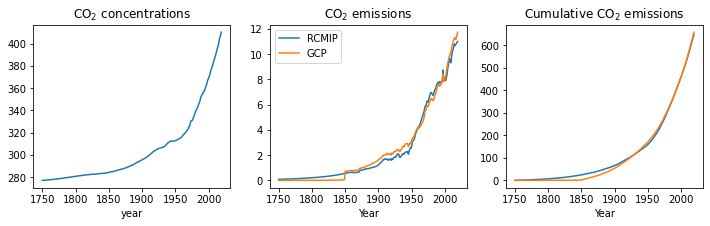

In [7]:
## first look at concentrations & emissions
fig,ax = plt.subplots(1,3,figsize=(12,3))
WMGHG_concs.carbon_dioxide.plot(ax=ax[0])
RCMIP_emissions.carbon_dioxide.plot(ax=ax[1],label='RCMIP')
RCMIP_emissions.carbon_dioxide.cumsum().plot(ax=ax[2])

## benchmark RCMIP against Global Carbon Project
import requests

r=requests.get('https://data.icos-cp.eu/licence_accept?ids=%5B%226QlPjfn_7uuJtAeuGGFXuPwz%22%5D')
GCP_CO2 = pd.read_excel(r.content,7,skiprows=15,index_col=0,engine='openpyxl').dropna(how='all').dropna(axis=1,how='all').iloc[:-1].astype(float)

GCP_CO2.iloc[:,:2].replace(np.nan,0).sum(axis=1).plot(ax=ax[1],label='GCP')
GCP_CO2.iloc[:,:2].replace(np.nan,0).sum(axis=1).cumsum().plot(ax=ax[2])

ax[0].set_title('CO$_2$ concentrations')
ax[1].set_title('CO$_2$ emissions')
ax[2].set_title('Cumulative CO$_2$ emissions')

ax[1].legend()

<AxesSubplot:>

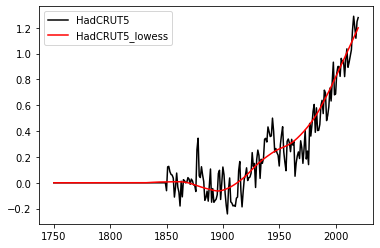

In [8]:
## import a temperature dataset to use for the tuning
### here we use HadCRUT5
import xarray as xr
import statsmodels.api as sm
LOWESS = sm.nonparametric.lowess

HC5 = xr.open_dataset('../../aux/input-data/Temperature-observations/HadCRUT.5.0.1.0.analysis.summary_series.global.annual.nc').tas_mean.to_pandas()
HC5.index = np.arange(1850,2021)
HC5 -= HC5.loc[1850:1900].mean()
HC5 = HC5.reindex(np.arange(1750,2021))
# extend back to 1750 (assuming zero anomaly relative to 1850-1900)
HC5.loc[1750:1849] = 0
HC5_smooth = pd.Series(*LOWESS(HC5.values,HC5.index,frac=0.2)[:,::-1].T)
HC5 = pd.concat([HC5,HC5_smooth],axis=1,keys=['HadCRUT5','HadCRUT5_lowess'])
HC5.plot(color=['k','r'])

Tuned r parameters: [3.38818890e+01 1.87789143e-02 2.67239543e+00 0.00000000e+00]


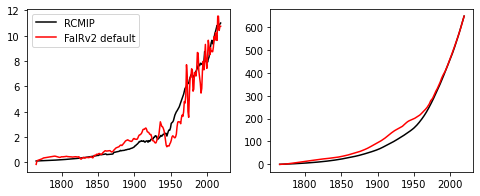

In [9]:
## proceed with the tuning, using RCMIP emissions as our benchmark emission source
base_params = get_gas_parameter_defaults()['default']
a = base_params.loc['a1':'a4','carbon_dioxide'].values
tau = base_params.loc['tau1':'tau4','carbon_dioxide'].values
PI_conc = 278
emis2conc = base_params.loc['emis2conc','carbon_dioxide']

CMIP6_cc_range = pd.read_csv('../../aux/parameter-sets/CMIP6_cc_reduced.csv',index_col=0)

r_base = np.array([CMIP6_cc_range.loc['r0'].mean(),
                  np.exp(np.log(CMIP6_cc_range.loc['rU']).mean()),
                  CMIP6_cc_range.loc['rT'].mean(),
                  0])

def tune_r0(x):
    r_tune = r_base.copy()
    r_tune[0] = x
    
    # start in 1765 as this is approximately the year concentrations are at "pre-industrial" levels
    C = WMGHG_concs.carbon_dioxide.loc[1765:2019].values
    T = HC5.HadCRUT5_lowess.loc[1765:2019].values
    diagnosed_emissions = invert_carbon_cycle_prescribed_T(C,T,a,tau,r_tune,PI_conc,emis2conc)['emms']
    cost = abs(diagnosed_emissions.sum() - RCMIP_emissions.carbon_dioxide.loc[1765:2019].sum())
    
    return cost

tuned_r0 = sp.optimize.newton(tune_r0,x0=30)
r_tuned = r_base.copy()
r_tuned[0] = tuned_r0

C = WMGHG_concs.carbon_dioxide.loc[1765:2019].values
T = HC5.HadCRUT5_lowess.loc[1765:2019].values
diagnosed_emissions = invert_carbon_cycle_prescribed_T(C,T,a,tau,r_tuned,PI_conc,emis2conc)['emms']
diagnosed_emissions.index=np.arange(1765,2020)

fig,ax = plt.subplots(1,2,figsize=(8,3))

RCMIP_emissions.carbon_dioxide.loc[1765:2019].plot(ax=ax[0],c='k',label='RCMIP')
diagnosed_emissions.plot(ax=ax[0],c='r',label='FaIRv2 default')

RCMIP_emissions.carbon_dioxide.loc[1765:2019].cumsum().plot(ax=ax[1],c='k')
diagnosed_emissions.cumsum().plot(ax=ax[1],c='r')

ax[0].legend()

print('Tuned r parameters:' , r_tuned)

## CH4

For CH4 we linearise the CH4 lifetime sensitivities from [Holmes et al., 2013](www.atmos-chem-phys.net/13/285/2013/) to it's own atmospheric burden, atmospheric temperatures & atmospheric water vapour concentration. For the maths + approximations, see appendix I.

The self-feedback is parameterised by $r_A = 0.00032$

The temperature and waver vapour feedbacks are parameterised by $r_T = -0.3$

We then tune the base CH4 lifetime, $\tau_1$, to observed concentrations and RCMIP emissions. The pre-industrial concentration is assumed to be 720 ppb.

Reference:

Holmes, C. D., Prather, M. J., Søvde, O. A., & Myhre, G. (2013). Future methane, hydroxyl, and their uncertainties: Key climate and emission parameters for future predictions. Atmospheric Chemistry and Physics, 13, 285–302. https://doi.org/10.5194/acp-13-285-2013

Tuned lifetime: 8.23


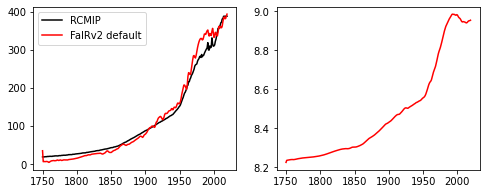

In [10]:
## since CH4 is short-lived, r_0 ~ tau_1
a = base_params.loc['a1':'a4','methane'].values
tau = base_params.loc['tau1':'tau4','methane'].values
PI_conc = 720
emis2conc = base_params.loc['emis2conc','methane']
r = base_params.loc['r0':'rA','methane'].values

def tune_tau(x):
    tau_tune = tau.copy()
    tau_tune[0] = x
    
    r_tune = r.copy()
    r_tune[0] = x
    r_tune[2] = -0.3
    r_tune[3] = 0.00032
    
    # start in 1765 as this is approximately the year concentrations are at "pre-industrial" levels
    C = WMGHG_concs.methane.loc[1750:2019].values
    T = HC5.HadCRUT5_lowess.loc[1750:2019].values
    diagnosed_emissions = invert_carbon_cycle_prescribed_T(C,T,a,tau_tune,r_tune,PI_conc,emis2conc)['emms']
    diagnosed_emissions.index = np.arange(1750,2020)
    
    cost = abs(diagnosed_emissions.loc[2000:2019].mean() - RCMIP_emissions.methane.loc[2000:2019].mean())
    
    return cost

tuned_tau = sp.optimize.newton(tune_tau,x0=9)
tau_tuned = tau.copy()
tau_tuned[0] = tuned_tau

r_tuned = r.copy()
r_tuned[0] = tuned_tau
r_tuned[2] = -0.3
r_tuned[3] = 0.00032

C = WMGHG_concs.methane.loc[1750:2019].values
T = HC5.HadCRUT5_lowess.loc[1750:2019].values
diagnosed_emissions = invert_carbon_cycle_prescribed_T(C,T,a,tau_tuned,r_tuned,PI_conc,emis2conc)
diagnosed_emissions.index = np.arange(1750,2020)

fig,ax = plt.subplots(1,2,figsize=(8,3))

RCMIP_emissions.methane.loc[1750:2019].plot(ax=ax[0],c='k',label='RCMIP')
diagnosed_emissions.emms.plot(ax=ax[0],c='r',label='FaIRv2 default')

(diagnosed_emissions.alpha*tuned_tau).plot(ax=ax[1],c='r')

ax[0].legend()

print('Tuned lifetime:' , round(tuned_tau,2))

## N2O

For N2O, it is possible to incorporate some lifetime sensitivity to its own atmospheric burden (eg. as is done in MAGICC), with very similar results. This is done by setting the N2O $r_A = -0.001$; computed by linearising the sensitivity of -0.065 in [Prather et al., 2015](https://doi.org/10.1002/2015JD023267).

However, in practice this makes virtually zero difference, so for the sake of simplicity we do not include this sensitivity by default.

We assume the pre-industrial concentration of N2O is 270 ppb, and then tune the lifetime such that the cumulative diagnosed emissions to present-day are equal to the RCMIP emissions.

References:

Prather, M. J., Hsu, J., DeLuca, N. M., Jackman, C. H., Oman, L. D., Douglass, A. R., … Funke, B. (2015). Measuring and modeling the lifetime of nitrous oxide including its variability. Journal of Geophysical Research: Atmospheres, 120(11), 5693–5705. https://doi.org/10.1002/2015JD023267

Tuned lifetime: 100.0
Tuned r0: 63.2


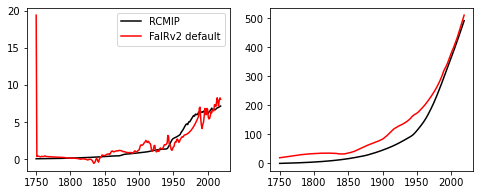

In [11]:
a = base_params.loc['a1':'a4','nitrous_oxide'].values
tau = base_params.loc['tau1':'tau4','nitrous_oxide'].values
PI_conc = 270
emis2conc = base_params.loc['emis2conc','nitrous_oxide']
r = base_params.loc['r0':'rA','nitrous_oxide'].values

def tune_tau(x):
    tau_tune = tau.copy()
    tau_tune[0] = x
    
    g1 = (x) * ( 1. - ( 1. + 100/(x) ) * np.exp(-100/(x)) )
    g0 = np.exp( - (x) * ( 1. - np.exp(-100/(x)) )  / g1 )
    
    r_tune = r.copy()
    r_tune[0] = g1*np.log(1/g0)
    
    # start in 1765 as this is approximately the year concentrations are at "pre-industrial" levels
    C = WMGHG_concs.nitrous_oxide.loc[1750:2019].values
    T = HC5.HadCRUT5_lowess.loc[1750:2019].values
    diagnosed_emissions = invert_carbon_cycle_prescribed_T(C,T,a,tau_tune,r_tune,PI_conc,emis2conc)['emms']
    diagnosed_emissions.index = np.arange(1750,2020)
    
    cost = abs(diagnosed_emissions.loc[1850:2019].sum() - RCMIP_emissions.nitrous_oxide.loc[1850:2019].sum())
    
    return cost

tuned_tau = sp.optimize.newton(tune_tau,x0=110)
tau_tuned = tau.copy()
tau_tuned[0] = tuned_tau

r_tuned = r.copy()
g1 = (tuned_tau) * ( 1. - ( 1. + 100/(tuned_tau) ) * np.exp(-100/(tuned_tau)) )
g0 = np.exp( - (tuned_tau) * ( 1. - np.exp(-100/(tuned_tau)) )  / g1 )
r_tuned[0] = g1*np.log(1/g0)

C = WMGHG_concs.nitrous_oxide.loc[1750:2019].values
T = HC5.HadCRUT5_lowess.loc[1750:2019].values
diagnosed_emissions = invert_carbon_cycle_prescribed_T(C,T,a,tau,r_tuned,PI_conc,emis2conc)['emms']
diagnosed_emissions.index=np.arange(1750,2020)

fig,ax = plt.subplots(1,2,figsize=(8,3))

RCMIP_emissions.nitrous_oxide.loc[1750:2019].plot(ax=ax[0],c='k',label='RCMIP')
diagnosed_emissions.plot(ax=ax[0],c='r',label='FaIRv2 default')

RCMIP_emissions.nitrous_oxide.loc[1750:2019].cumsum().plot(ax=ax[1],c='k')
diagnosed_emissions.cumsum().plot(ax=ax[1],c='r')

ax[0].legend()

print('Tuned lifetime:' , round(tuned_tau,1))
print('Tuned r0:' , round(r_tuned[0],1))

## Other WMGHGs

By default in FaIRv2 all other well-mixed greenhouse gases have:
- a single gas pool (like CH$_4$ and N$_2$O)
- no sensitivities ($r_u = r_T = r_a = 0$)

We take default lifetimes, radiative efficiencies and oxone depletion potentials for all other species from the 2018 WMO Ozone Assessment, appendix A.

Reference:

WMO (World Meteorological Organization). (2018). Scientific Assessment of Ozone Depletion: 2018. Retrieved from https://www.esrl.noaa.gov/csl/assessments/ozone/2018/#intro-1

In [12]:
WMGHG_data = pd.DataFrame(index = WMGHG_concs.columns,columns = ['MW','tau','RE','ODP'],dtype=float)

WMGHG_data.loc["c2f6"]=[138.01,10000, 0.25,0]
WMGHG_data.loc["c3f8"]=[188.02,2600, 0.28,0]
WMGHG_data.loc["c4f10"]=[238.027,2600, 0.36,0]
WMGHG_data.loc["c5f12"]=[288.034,4100, 0.41,0]
WMGHG_data.loc["c6f14"]=[338.042,3100, 0.44,0]
WMGHG_data.loc["c7f16"]=[388.049,3000, 0.5,0]
WMGHG_data.loc["c8f18"]=[438.06,3000, 0.55,0]
WMGHG_data.loc["c_c4f8"]=[200.03,3200, 0.32,0]

WMGHG_data.loc["carbon_tetrachloride"]=[153.82,32, 0.174,0.89]
WMGHG_data.loc["cf4"]=[88.0043,50000, 0.09,0]

WMGHG_data.loc["cfc113"]=[187.376,93, 0.3,0.81]
WMGHG_data.loc["cfc114"]=[170.92,189, 0.31,0.5]
WMGHG_data.loc["cfc115"]=[154.466,540, 0.2,0.26]
WMGHG_data.loc["cfc11"]=[137.37,52, 0.26,1]
WMGHG_data.loc["cfc12"]=[120.91,102, 0.32,0.77]

WMGHG_data.loc["ch2cl2"]=[84.93,0.4928266345416712, 0.028,0]
WMGHG_data.loc["ch3ccl3"]=[133.4,5, 0.07,0.15]
WMGHG_data.loc["chcl3"]=[119.37,0.5010404117840324, 0.07,0]

WMGHG_data.loc["halon1202"]=[209.82,2.5, 0.27,1.7]
WMGHG_data.loc["halon1211"]=[165.36,16, 0.29,7.3]
WMGHG_data.loc["halon1301"]=[148.91,72, 0.3,17.1]
WMGHG_data.loc["halon2402"]=[259.823,28, 0.31,15.7]

WMGHG_data.loc["hcfc141b"]=[116.94,9.4, 0.16,0.086]
WMGHG_data.loc["hcfc142b"]=[100.49,18, 0.19,0.04]
WMGHG_data.loc["hcfc22"]=[86.47,11.9, 0.21,0.029]

WMGHG_data.loc["hfc125"]=[120.02,30, 0.23,0]
WMGHG_data.loc["hfc134a"]=[102.03,14, 0.16,0]
WMGHG_data.loc["hfc143a"]=[84.04,51, 0.16,0]
WMGHG_data.loc["hfc152a"]=[66.05,1.6, 0.1,0]
WMGHG_data.loc["hfc227ea"]=[170.03,36, 0.26,0]
WMGHG_data.loc["hfc236fa"]=[152.039,213, 0.24,0]
WMGHG_data.loc["hfc23"]=[70.01,228, 0.18,0]
WMGHG_data.loc["hfc245fa"]=[134.05,7.9, 0.24,0]
WMGHG_data.loc["hfc32"]=[52.02,5.4, 0.11,0]
WMGHG_data.loc["hfc365mfc"]=[148.074,8.9, 0.22,0]
WMGHG_data.loc["hfc4310mee"]=[252.055,17, 0.359,0]

WMGHG_data.loc["methyl_bromide"]=[94.94,0.8, 0.004,0.57]
WMGHG_data.loc["methyl_chloride"]=[50.49,0.9, 0.004,0.015]
WMGHG_data.loc["nf3"]=[71,569, 0.2,0]
WMGHG_data.loc["sf6"]=[146.06,3200, 0.57,0]
WMGHG_data.loc["so2f2"]=[102.06,36, 0.2,0]

# II. Forcing parameters

## CO2, CH4 & N2O

Here we tune the forcing parameters to match the results of [Etminan et al., 2016](https://doi.org/10.1002/2016GL071930) as closely as possible. We exclude the interactions between species, noting that these are only significant for extreme high emission scenarios (RCP8.5). Other feedbacks and uncertainties not included in SCMs are very likely more important with regards to the accuracy of simple models under this "worst-case" scenario.

Reference:

Etminan, M., Myhre, G., Highwood, E. J., & Shine, K. P. (2016). Radiative forcing of carbon dioxide, methane, and nitrous oxide: A significant revision of the methane radiative forcing. Geophysical Research Letters, 43(24), 12,614-12,623. https://doi.org/10.1002/2016GL071930

In [13]:
import PyPDF2
import os

# here we download and read in table S2 from Etminan et al, 2016
os.system('wget "https://agupubs.onlinelibrary.wiley.com/action/downloadSupplement?doi=10.1002%2F2016GL071930&file=grl55302-sup-0001-Supplementary.pdf" -O ../../aux/input-data/_hidden/olbl.pdf')
pdffile = PyPDF2.PdfFileReader('../../aux/input-data/_hidden/olbl.pdf')
OLBLtable = pdffile.getPage(2).extractText().replace('\n \n',',').replace('\n','').split(',')[42:-1]
OLBLtable2 = pdffile.getPage(3).extractText().replace('\n \n',',').replace('\n','').split(',')[36:-1]
OLBL_df = pd.concat([pd.DataFrame([OLBLtable[i*15:(i+1)*15] for i in np.arange(38)],columns = ['index','CO2_conc','CH4_conc','N2O_conc','sw','LW_inst_cl','LW_inst','LW_adj','Net','change_rel_to_old_fits','CO2_rf','N2O_rf','CH4_rf','rf_SUM','err_in_new_fits']).set_index('index').iloc[:-1],pd.DataFrame([OLBLtable2[i*15:(i+1)*15] for i in np.arange(11)],columns = ['index','CO2_conc','CH4_conc','N2O_conc','sw','LW_inst_cl','LW_inst','LW_adj','Net','change_rel_to_old_fits','CO2_rf','N2O_rf','CH4_rf','rf_SUM','err_in_new_fits']).set_index('index').iloc[:-1]]).apply(pd.to_numeric)
OLBL_df.loc[1] = [389,1800,323,0,0,0,0,0,np.nan,0,0,0,0,np.nan]

In [14]:
## Tune CO2 to f1 & f3 as in Shi (1992) based on present-day N2O & CH4
CO2_rf = OLBL_df.query("CH4_conc==1800&N2O_conc==323").Net.values.flatten()
CO2_ppm = OLBL_df.query("CH4_conc==1800&N2O_conc==323").CO2_conc.values.flatten()
_lr = OLSE_NORM(np.array([np.sqrt(CO2_ppm)-np.sqrt(278),np.log(CO2_ppm/278)]).T,CO2_rf[:,np.newaxis])

print('CO2 f1 =',_lr['coefs'].flatten()[1],'\nCO2 f3 =',_lr['coefs'].flatten()[0])
print('\nF_2xCO2 = ',_lr['coefs'].flatten()[0]*(np.sqrt(278*2)-np.sqrt(278))+_lr['coefs'].flatten()[1]*np.log(2))

CO2 f1 = 4.565090918560799 
CO2 f3 = 0.08608124523763294

F_2xCO2 =  3.7587845458626985


In [15]:
print('CH4 f3 = ',(OLBL_df.query("CO2_conc==389&N2O_conc==323").Net/(np.sqrt(OLBL_df.query("CO2_conc==389&N2O_conc==323").CH4_conc) - np.sqrt(1800))).dropna().mean())

CH4 f3 =  0.03800722764327395


In [16]:
print('N2O f3 = ',(OLBL_df.query("CO2_conc==389&CH4_conc==1800").Net/(np.sqrt(OLBL_df.query("CO2_conc==389&CH4_conc==1800").N2O_conc) - np.sqrt(323))).dropna().mean())

N2O f3 =  0.10585479945423873


In [17]:
## check errors vs Etminan:

OLBL_df['FaIRv2'] = 4.57*np.log(OLBL_df.CO2_conc/389) +\
                    0.086*(np.sqrt(OLBL_df.CO2_conc)-np.sqrt(389)) +\
                    0.038*(np.sqrt(OLBL_df.CH4_conc)-np.sqrt(1800)) +\
                    0.106*(np.sqrt(OLBL_df.N2O_conc)-np.sqrt(323))

rf_plot_data = OLBL_df[['CO2_conc','CH4_conc','N2O_conc','Net','rf_SUM','FaIRv2']].set_index(['CO2_conc','CH4_conc','N2O_conc']).sort_index().rename({'Net':'OLBL','rf_SUM':'Etminan'},axis=1)

In [18]:
rf_plot_data['Etminan_diff'] = rf_plot_data.Etminan - rf_plot_data.OLBL
rf_plot_data['FaIRv2_diff'] = rf_plot_data.FaIRv2 - rf_plot_data.OLBL

In [19]:
rf_plot_data = pd.concat([rf_plot_data.set_index('OLBL',append=True)[['Etminan','Etminan_diff']].rename({'Etminan':'abs','Etminan_diff':'diff'},axis=1),
           rf_plot_data.set_index('OLBL',append=True)[['FaIRv2','FaIRv2_diff']].rename({'FaIRv2':'abs','FaIRv2_diff':'diff'},axis=1)],
          axis=0,keys=['Etminan','FaIRv2'],names=['source'])

set some matplotlib rcParams

In [20]:
matplotlib.rcParams['font.family']='Helvetica'
matplotlib.rcParams['font.size']=11

matplotlib.rcParams['axes.formatter.limits']=-3,3

matplotlib.rcParams['legend.frameon']=False

plt.rcParams['pdf.fonttype'] = 42

''

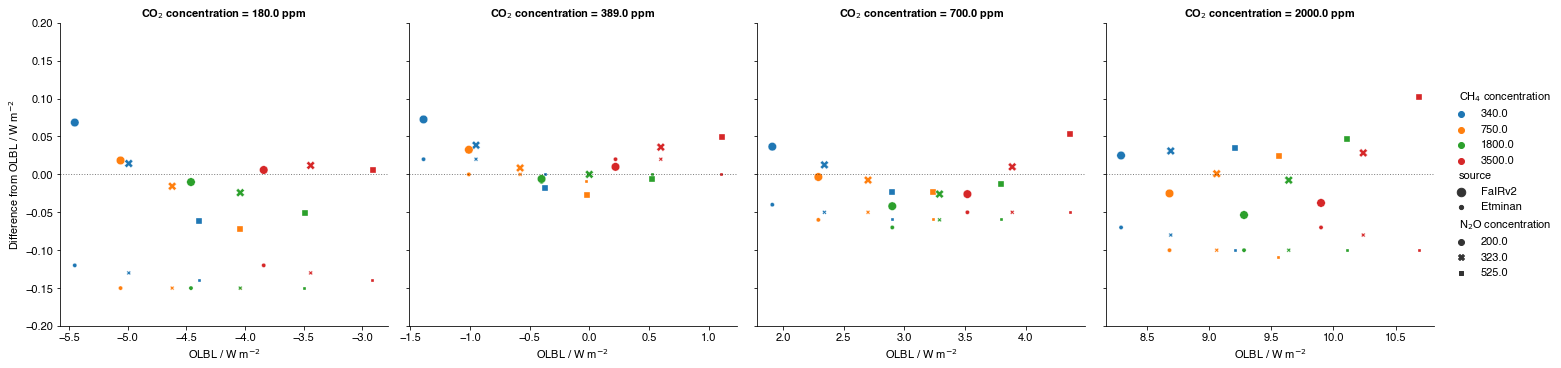

In [21]:
g=sn.relplot(data=rf_plot_data.reset_index().rename({'CO2_conc':'CO$_2$ concentration','CH4_conc':'CH$_4$ concentration','N2O_conc':'N$_2$O concentration'},axis=1),
             x='OLBL',
             y='diff',
             col='CO$_2$ concentration',
             hue='CH$_4$ concentration',
             size='source',
             size_order=['FaIRv2','Etminan'],
             style='N$_2$O concentration',
             facet_kws=dict(sharex=False),
             palette='tab10')

g.set(ylim=[-0.2,0.2],ylabel='Difference from OLBL / W m$^{-2}$',xlabel='OLBL / W m$^{-2}$')
g.set_titles(col_template="CO$_2$ concentration = {col_name} ppm",fontweight='bold')
[a.axhline(0,ls=':',lw=1,color='k',alpha=0.5) for a in g.axes.flatten()]

[g.fig.savefig('../../docs/manuscript/figures/FigS1.'+x,dpi=600,bbox_inches='tight') for x in ['png','pdf']]
''

## Aerosol forcing

Rather than select parameters from (eg.) literature values, or tune to specific datasets, for consistency throughout the FaIRv2.0.0 study we will use the central estimate from the constrained perturbed parameter ensemble (see `FULL-compute`, `global-warming-index` & `FULL-constrain` notebooks) as the default aerosol parameters.

In [22]:
## choose the datasets to use here:
datasets_to_use = ['HadCRUT5','HadCRUT4','NOAA','GISTEMP','CW','BERKELEY']

FULL_probabilities = pd.concat([pd.read_hdf('../../aux/parameter-sets/perturbed-parameters/FULL_selection_probability-'+x+'.h5') for x in datasets_to_use],axis=1,keys=datasets_to_use)
FULL_ensemble_selection = FULL_probabilities.mean(axis=1)>np.random.random(FULL_probabilities.shape[0])

ALL_mems = [x.split('/')[-1].split('.')[0] for x in glob.glob('../../aux/parameter-sets/perturbed-parameters/gas_params/*.h5')]

CONSTRAINED_f_aer = []

for mem_range in ALL_mems:
    
    CONSTRAINED_f_aer += [pd.read_hdf('../../aux/parameter-sets/perturbed-parameters/gas_params/'+mem_range+'.h5').reindex(['f1','f2','f3','PI_conc']).reindex(['so2','so2|aci','oc','oc|aci','bc','bc|aci'],axis=1,level=1)]
    
CONSTRAINED_f_aer = pd.concat(CONSTRAINED_f_aer,axis=1).reindex(FULL_ensemble_selection.index[FULL_ensemble_selection],axis=1,level=0)

In [23]:
## get aerosol emissions to validate
aer_emms = RCMIP_to_FaIR_input_emms('ssp245').interpolate().loc[1750:2300,['so2','bc','oc']]
aer_emms -= aer_emms.loc[1750]

aer_defaults = CONSTRAINED_f_aer.groupby(axis=1,level=1).median()

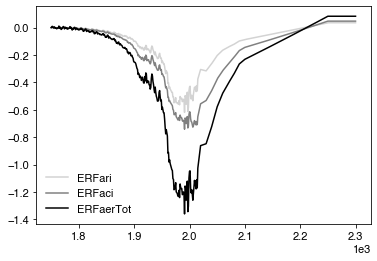

In [24]:
default_ERFari = (aer_emms*aer_defaults.loc['f2']).sum(axis=1)
default_ERFaci = aer_defaults.loc['f1','so2|aci']*np.log(1+aer_emms.so2/aer_defaults.loc['PI_conc','so2'])+\
                 aer_defaults.loc['f2','oc|aci']*aer_emms.oc+\
                 aer_defaults.loc['f2','bc|aci']*aer_emms.bc

default_ERFari.plot(label='ERFari',c='lightgrey')
default_ERFaci.plot(label='ERFaci',c='grey')
(default_ERFaci+default_ERFari).plot(label='ERFaerTot',c='k')
plt.legend()

In [25]:
aer_defaults

,bc,bc|aci,oc,oc|aci,so2,so2|aci
f1,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,-0.958111
f2,5.676699e-02,-0.008013,-1.774046e-02,-0.008013,-0.004745,0.000000
f3,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000
PI_conc,1.000000e-15,NaN,1.000000e-15,NaN,171.131397,NaN


## Ozone forcing

For ozone forcing, we use recent updates from [Thornhill et al., 2021](https://acp.copernicus.org/articles/21/853/2021/), & [Skeie et al., 2021.](https://doi.org/10.1038/s41612-020-00131-0). Thornhill et al. provides radiative efficiency coefficients for contributions to ozone forcing from CH4, NOx, CO+NMVOCs, N2O and ODSs. Skeie et al. provides historical timeseries of ozone forcing.

References:

Skeie, R. B., Myhre, G., Hodnebrog, Ø., Cameron-Smith, P. J., Deushi, M., Hegglin, M. I., … Wu, T. (2020). Historical total ozone radiative forcing derived from CMIP6 simulations. Npj Climate and Atmospheric Science, 3(1), 1–10. https://doi.org/10.1038/s41612-020-00131-0

Thornhill, G. D., Collins, W. J., Kramer, R. J., Olivié, D., Skeie, R. B., O’Connor, F. M., … Zhang, J. (2021). Effective radiative forcing from emissions of reactive gases and aerosols – a multi-model comparison. Atmospheric Chemistry and Physics, 21(2), 853–874. https://doi.org/10.5194/acp-21-853-2021

### import data

In [26]:
import glob

## ozone timeseries:
def get_skeie_ts(fname):
    data = pd.read_csv(fname,skiprows=3,sep=';',index_col=0)['NET adj.']
    data.index = [int(x[:4]) for x in data.index]
    data.name = fname.split('/')[-1].split('_')[2]
    return data/1000

skeie_files = glob.glob('../../aux/input-data/_hidden/histO3/Kernel_output/TotRF/CMIP6/*.csv')

skeie_o3_data = pd.concat([get_skeie_ts(x) for x in skeie_files],axis=1)

oslo_CTM_data = get_skeie_ts('../../aux/input-data/_hidden/histO3/Kernel_output/TotRF/OsloCTM3/RF_NRFmethod_OsloCTM3_net_yearly.csv')
skeie_o3_data = pd.concat([skeie_o3_data,oslo_CTM_data],axis=1)

In [27]:
good_models = ['BCC-ESM1', 'CESM2-WACCM', 'GFDL-ESM4', 'GISS-E2-1-H', 'MRI-ESM2-0', 'OsloCTM3']

# take multi-model mean of "good" models
skeie_o3_ts = skeie_o3_data[good_models].mean(axis=1).replace(np.nan,0)
skeie_o3_ts.loc[1750] = -0.03
skeie_o3_ts.sort_index(inplace=True)

# remove OsloCTM3 bias relative to MMM for 2014-> data
skeie_o3_ts.loc[2014:] += skeie_o3_data.loc[2010,good_models].mean() - skeie_o3_data.loc[2010,'OsloCTM3']

Thornhill et al., 2021 contributions to 1850-2014 O$_3$ RF are as follows:

species|contribution
---|---
CH4|0.14
NOx|0.2
CO+NMVOC|0.11
CO|0.067
NMVOC|0.043
N2O|0.03
ODS|-0.11
Tot|0.37

Note the disaggregation of CO+NMVOC is based on Stevenson et al., 2013.

References:

Stevenson, D. S., Young, P. J., Naik, V., Lamarque, J.-F., Shindell, D. T., Voulgarakis, A., … Archibald, A. (2013). Tropospheric ozone changes, radiative forcing and attribution to emissions in the Atmospheric Chemistry and Climate Model Intercomparison Project (ACCMIP). Atmospheric Chemistry and Physics, 13(6), 3063–3085. https://doi.org/10.5194/acp-13-3063-2013

In [28]:
# scale Thornhill coefficients to reproduce the Skeie timeseries
skeie_th_sf = skeie_o3_ts.loc[2014]/0.37

In [29]:
# CH4 sensitivity:
print('ch4|o3 f2 :',skeie_th_sf*0.14/(WMGHG_concs.methane.loc[2014]-WMGHG_concs.methane.loc[1850]))

ch4|o3 f2 : 0.00016317506750963435


In [30]:
# NOx sensitivity
print('nox|o3 f2 :',skeie_th_sf*0.2/(RCMIP_emissions.nox.loc[2014]-RCMIP_emissions.nox.loc[1850]))

nox|o3 f2 : 0.0016775519038973365


In [31]:
# CO sensitivity
print('co|o3 f2 :',skeie_th_sf*0.067/(RCMIP_emissions.co.loc[2014]-RCMIP_emissions.co.loc[1850]))

co|o3 f2 : 0.00014460108027409055


In [32]:
# NMVOC sensitivity
print('mnvoc|o3 f2 :',skeie_th_sf*0.043/(RCMIP_emissions.nmvoc.loc[2014]-RCMIP_emissions.nmvoc.loc[1850]))

mnvoc|o3 f2 : 0.000307551501881188


In [33]:
# NMVOC sensitivity
print('n2o|o3 f2 :',skeie_th_sf*0.03/(WMGHG_concs.nitrous_oxide.loc[2014]-WMGHG_concs.nitrous_oxide.loc[1850]))

n2o|o3 f2 : 0.000662962638642048


For ODS sensitivity, we parameterise the contribution of individual ODSs via their contribution to estimated equivalent effective stratospheric chlorine (eesc, [Velders et al., 2014](https://doi.org/10.5194/acp-14-2757-2014)).

The estimated contribution to eesc is:

$$
\text{eesc} = \bar{f} * ( n_{\text{Cl}} + 45 * n_{\text{Br}} )
$$

with $\bar{f}$ as the time-independent fractional release factor ([Engel et al., 2018](https://doi.org/10.5194/acp-18-601-2018)), and $n_x$ as the number of atoms of that element in the specie.

References:

Velders, G. J. M., & Daniel, J. S. (2014). Uncertainty analysis of projections of ozone-depleting substances: Mixing ratios, EESC, ODPs, and GWPs. Atmospheric Chemistry and Physics, 14(6), 2757–2776. https://doi.org/10.5194/acp-14-2757-2014

Engel, A., Bönisch, H., Ostermöller, J., Chipperfield, M. P., Dhomse, S., & Jöckel, P. (2018). A refined method for calculating equivalent effective stratospheric chlorine. Atmospheric Chemistry and Physics, 18(2), 601–619. https://doi.org/10.5194/acp-18-601-2018

In [34]:
ODS = ['carbon_tetrachloride', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch3ccl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'methyl_bromide', 'methyl_chloride', 'halon1202','chcl3','ch2cl2']
n_Cl = pd.Series(dict(zip(ODS,[4,3,2,1,3,2,3,0,0,0,2,1,1,0,1,0,3,2])))
n_Br = pd.Series(dict(zip(ODS,[0,0,0,0,0,0,0,1,1,2,0,0,0,1,0,2,0,0])))
frac_rel = pd.Series(dict(zip(ODS,[0.56,0.3,0.13,0.07,0.47,0.24,0.61,0.65,0.32,0.66,0.34,0.17,0.15,0.6,0.44,0.67,0,0])))

In [35]:
eesc = (WMGHG_concs.loc[2014,ODS]-WMGHG_concs.loc[1850,ODS]) * frac_rel * (n_Cl + 45*n_Br)

In [36]:
ODS_o3_re = eesc*skeie_th_sf*-0.11/eesc.sum() / (WMGHG_concs.loc[2014,ODS]-WMGHG_concs.loc[1850,ODS])
print('ODS|o3 f2 :')
print(ODS_o3_re)

ODS|o3 f2 :
carbon_tetrachloride   -0.254957
cfc113                 -0.102438
cfc114                 -0.029593
cfc115                 -0.007967
cfc11                  -0.160486
cfc12                  -0.054634
ch3ccl3                -0.208291
halon1211              -3.329239
halon1301              -1.639010
halon2402              -6.760916
hcfc141b               -0.077398
hcfc142b               -0.019349
hcfc22                 -0.017073
methyl_bromide         -3.073144
methyl_chloride        -0.050081
halon1202              -6.863354
chcl3                  -0.000000
ch2cl2                 -0.000000
dtype: float64


## Stratospheric water vapour
Parameterised as a linear function of CH4 concentrations.

In [37]:
print('methane|strat_h2o f2:',0.05 / (WMGHG_concs.methane.loc[2019]-WMGHG_concs.methane.loc[1750]))

methane|strat_h2o f2: 4.369480726010973e-05


## Black Carbon on snow
Parameterised as a linear function of black carbon emissions.

In [38]:
print('bc|bc_on_snow f2:',0.08 / (RCMIP_emissions.bc.loc[2019]-RCMIP_emissions.bc.loc[1750]))

bc|bc_on_snow f2: 0.011585926068486678


## Contrail forcing
Parameterised as a linear function of NOx emissions from aviation. 2018 value taken from [Lee et al., 2021](https://www.sciencedirect.com/science/article/pii/S1352231020305689)

Reference:

Lee, D. S., Fahey, D. W., Skowron, A., Allen, M. R., Burkhardt, U., Chen, Q., … Wilcox, L. J. (2021). The contribution of global aviation to anthropogenic climate forcing for 2000 to 2018. Atmospheric Environment, 244, 117834. https://doi.org/10.1016/j.atmosenv.2020.117834

In [39]:
print('nox_avi|contrails f2:',0.0574 / (RCMIP_emissions.nox_avi.loc[2018]-RCMIP_emissions.nox_avi.loc[1750]))

nox_avi|contrails f2: 0.016441835328321962


# III. Climate response parameters

Rather than select parameters from (eg.) literature values, or tune to specific datasets, for consistency throughout the FaIRv2.0.0 study we will use the central estimates of TCR & ECS from the constrained perturbed parameter ensemble (see `FULL-compute`, `global-warming-index` & `FULL-constrain` notebooks) for the default climate response parameters.

In [40]:
## choose the datasets to use here:
datasets_to_use = ['HadCRUT5','HadCRUT4','NOAA','GISTEMP','CW','BERKELEY']

FULL_probabilities = pd.concat([pd.read_hdf('../../aux/parameter-sets/perturbed-parameters/FULL_selection_probability-'+x+'.h5') for x in datasets_to_use],axis=1,keys=datasets_to_use)
FULL_ensemble_selection = FULL_probabilities.mean(axis=1)>np.random.random(FULL_probabilities.shape[0])

ALL_mems = [x.split('/')[-1].split('.')[0] for x in glob.glob('../../aux/parameter-sets/perturbed-parameters/gas_params/*.h5')]

CONSTRAINED_thermal = []

for mem_range in ALL_mems:
    
    CONSTRAINED_thermal += [pd.read_hdf('../../aux/parameter-sets/perturbed-parameters/climresp_params/FULL/'+mem_range+'.h5')]
    
CONSTRAINED_thermal = pd.concat(CONSTRAINED_thermal,axis=1).reindex(FULL_ensemble_selection.index[FULL_ensemble_selection],axis=1,level=0)

In [41]:
## just using central parameter estimates results in a slightly lowered TCR / ECS relative to the ensemble median
## therefore use central estimates for d1-3, q1; and set q2, q3 to return "correct" TCR/ECS values
d1 = 0.903
d2 = 7.92
d3 = 355
q1 = 0.180

TCR = 1.79
ECS = 3.24
F_2x = 3.759

v1 = (1-(d1/69.66) * (1-np.exp(-69.66/d1)) )
v2 = (1-(d2/69.66) * (1-np.exp(-69.66/d2)) )
v3 = (1-(d3/69.66) * (1-np.exp(-69.66/d3)) )

q3 = (((TCR/F_2x) - q1*(v1-v2) - (ECS/F_2x)*v2) / (v3-v2))
q2 = (ECS/F_2x - q1 -  q3)

pd.DataFrame([[d1,d2,d3],[q1,q2,q3]],index=['d','q'],columns=pd.MultiIndex.from_product([['default'],[1,2,3]]))

default                     
        1        2           3
d   0.903  7.92000  355.000000
q   0.180  0.29684    0.385091

# Bring it all together & save default parameter set!

In [42]:
default_params = pd.DataFrame(columns=WMGHG_concs.columns,index=['a1', 'a2', 'a3', 'a4', 'tau1', 'tau2', 'tau3', 'tau4', 'r0', 'rC','rT', 'rA', 'PI_conc', 'emis2conc', 'f1', 'f2', 'f3'])

#CO2
default_params.loc[:,'carbon_dioxide'] = [0.2173,0.2240,0.2824,0.2763,1e9,394.4,36.54,4.304,33.9,0.0188,2.67,0,278,28.966/(5.148 * 12),4.57,0,0.086]

#CH4
default_params.loc[:,'methane'] = [1,0,0,0,8.25,0,0,0,8.25,0,-0.3,0.00032,720,28.966/(5.148 * 16),0,0,0.038]

#N2O (measured in N2O-N2)
default_params.loc[:,'nitrous_oxide'] = [1,0,0,0,100,0,0,0,63.2,0,0,0,270,28.966/(5.148 * 28),0,0,0.106]

#Other WMGHGs
default_params.loc[:,WMGHG_data.dropna().index] = 0
default_params.loc['a1',WMGHG_data.dropna().index] = 1

## the r0 calculation for very large tau values is unstable due to float limits, so we scale the tau values by 1/100
default_params.loc['tau1',WMGHG_data.dropna().index] = WMGHG_data.dropna().tau/100
g1 = (WMGHG_data.dropna().tau/100) * ( 1. - ( 1. + 100/(WMGHG_data.dropna().tau/100) ) * np.exp(-100/(WMGHG_data.dropna().tau/100)) )
g0 = np.exp( - (WMGHG_data.dropna().tau/100) * ( 1. - np.exp(-100/(WMGHG_data.dropna().tau/100)) )  / g1 )
default_params.loc['r0',WMGHG_data.dropna().index] = g1*np.log(100/g0)
default_params.loc['PI_conc',WMGHG_data.dropna().index] =  1e-15 + WMGHG_concs.loc[1750,WMGHG_data.dropna().index]
default_params.loc['emis2conc',WMGHG_data.dropna().index] = 28.966/(5.148 * WMGHG_data.dropna().MW)
default_params.loc['f2',WMGHG_data.dropna().index] = WMGHG_data.dropna().RE

#Aerosols (CONSTRAINED central estimates)
## note that the emis2conc is 1 since emissions are converted directly to concs
## the emissions units are: MtSO2, MtNO2, MtCO, MtNMVOC
default_params.loc[:,'so2'] = [1,0,0,0,1,0,0,0,1,0,0,0,170.6,1,0,-0.004740,0]
default_params.loc[:,'nox'] = [1,0,0,0,1,0,0,0,1,0,0,0,1e-15,1,0,0,0]
default_params.loc[:,'nox_avi'] = [1,0,0,0,1,0,0,0,1,0,0,0,1e-15,1,0,0,0]
default_params.loc[:,'co'] = [1,0,0,0,1,0,0,0,1,0,0,0,1e-15,1,0,0,0]
default_params.loc[:,'nmvoc'] = [1,0,0,0,1,0,0,0,1,0,0,0,1e-15,1,0,0,0]
default_params.loc[:,'bc'] = [1,0,0,0,1,0,0,0,1,0,0,0,1e-15,1,0,0.056672,0]
default_params.loc[:,'nh3'] = [1,0,0,0,1,0,0,0,1,0,0,0,1e-15,1,0,0,0]
default_params.loc[:,'oc'] = [1,0,0,0,1,0,0,0,1,0,0,0,1e-15,1,0,-0.017649,0]

for species in default_params.columns:
    if species=='carbon_dioxide':
        continue
    else:
        default_params.loc['tau2':'tau4',species]=1

#Ozone RFs
default_params.loc[:,'methane|o3'] = np.nan
default_params.loc['f1':'f3','methane|o3'] = 0
default_params.loc['f2','methane|o3'] = 0.000163

default_params.loc[:,'co|o3'] = np.nan
default_params.loc['f1':'f3','co|o3'] = 0
default_params.loc['f2','co|o3'] = 0.000145

default_params.loc[:,'nox|o3'] = np.nan
default_params.loc['f1':'f3','nox|o3'] = 0
default_params.loc['f2','nox|o3'] = 0.00168

default_params.loc[:,'nmvoc|o3'] = np.nan
default_params.loc['f1':'f3','nmvoc|o3'] = 0
default_params.loc['f2','nmvoc|o3'] = 0.000308

default_params.loc[:,'nitrous_oxide|o3'] = np.nan
default_params.loc['f1':'f3','nitrous_oxide|o3'] = 0
default_params.loc['f2','nitrous_oxide|o3'] = 0.000663

#ODS RFs
for species in ODS_o3_re.index:
    default_params.loc[:,species+'|o3'] = np.nan
    default_params.loc['f1':'f3',species+'|o3'] = 0
    default_params.loc['f2',species+'|o3'] = ODS_o3_re.loc[species]

#strat_h2o
default_params.loc[:,'methane|strat_h2o'] = np.nan
default_params.loc['f1':'f3','methane|strat_h2o'] = 0
default_params.loc['f2','methane|strat_h2o'] = 4.37e-05
    
#BC on snow
default_params.loc[:,'bc|bc_on_snow'] = np.nan
default_params.loc['f1':'f3','bc|bc_on_snow'] = 0
default_params.loc['f2','bc|bc_on_snow'] = 0.0116

#Contrails
default_params.loc[:,'nox_avi|contrails'] = np.nan
default_params.loc['f1':'f3','nox_avi|contrails'] = 0
default_params.loc['f2','nox_avi|contrails'] =  0.0164

#ari and aci from CONSTRAINED
default_params.loc[:,'so2|aci'] = np.nan
default_params.loc['f1':'f3','so2|aci'] = 0
default_params.loc['f1','so2|aci'] = -0.955789
default_params.loc[:,'bc|aci'] = np.nan
default_params.loc['f1':'f3','bc|aci'] = 0
default_params.loc['f2','bc|aci'] = -0.008013
default_params.loc[:,'oc|aci'] = np.nan
default_params.loc['f1':'f3','oc|aci'] = 0
default_params.loc['f2','oc|aci'] = -0.008013
    
default_params = pd.concat([default_params],keys=['default'],axis=1)

In [43]:
## save parameter set
# default_params.to_csv('../../aux/parameter-sets/Complete_gas_cycle_params.csv')

,$a_1$,$a_2$,$a_3$,$a_4$,$\tau_1$,$\tau_2$,$\tau_3$,$\tau_4$,$r_0$,$r_u$,$r_T$,$r_a$,PI_conc,emis2conc,$f_1$,$f_2$,$f_3$
bc,1.0,0.0,0.0,0.0,1.00,1.0,1.0,1.0,1.000000,0.0,0.0,0.0,1.000000e-15,1.000000,0.000000,0.056672,0.0
bc|aci,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,-0.008013,0.0
bc|bc_on_snow,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.011600,0.0
c2f6,1.0,0.0,0.0,0.0,100.00,1.0,1.0,1.0,184.899588,0.0,0.0,0.0,1.000000e-15,0.040770,0.000000,0.250000,0.0
c3f8,1.0,0.0,0.0,0.0,26.00,1.0,1.0,1.0,132.783840,0.0,0.0,0.0,1.000000e-15,0.029926,0.000000,0.280000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
oc|aci,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,-0.008013,0.0
sf6,1.0,0.0,0.0,0.0,32.00,1.0,1.0,1.0,151.250973,0.0,0.0,0.0,1.000000e-15,0.038523,0.000000,0.570000,0.0
so2,1.0,0.0,0.0,0.0,1.00,1.0,1.0,1.0,1.000000,0.0,0.0,0.0,1.706000e+02,1.000000,0.000000,-0.004740,0.0
so2f2,1.0,0.0,0.0,0.0,0.36,1.0,1.0,1.0,2.017861,0.0,0.0,0.0,1.000000e-15,0.055131,0.000000,0.200000,0.0


In [44]:
#create a grouper for easy aggregation of RF in future
RF_categories = pd.Series(index=default_params.columns.levels[1])

RF_categories.loc[['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114',
                   'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211',
                   'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125',
                   'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23',
                   'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee' ,'nf3', 'sf6',
                   'so2f2', 'halon1202', 'methyl_bromide', 'methyl_chloride']] = 'other_wmghgs'

RF_categories.loc['carbon_dioxide'] = 'carbon_dioxide'
RF_categories.loc['methane'] = 'methane'
RF_categories.loc['nitrous_oxide'] = 'nitrous_oxide'

RF_categories.loc[[x for x in RF_categories.index if x.split('|')[-1]=='o3']] = 'ozone'
RF_categories.loc[['so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc']] = 'ari'
RF_categories.loc[[x for x in RF_categories.index if x.split('|')[-1]=='aci']] = 'aci'
RF_categories.loc[[x for x in RF_categories.index if x.split('|')[-1]=='strat_h2o']] = 'strat_h2o'
RF_categories.loc[[x for x in RF_categories.index if x.split('|')[-1]=='contrails']] = 'contrails'
RF_categories.loc[[x for x in RF_categories.index if x.split('|')[-1]=='bc_on_snow']] = 'bc_on_snow'

RF_categories.to_csv('../../aux/FaIRv2.0.0-alpha_RF_categories.csv')

Quick sanity test to make sure the default parameters aren't throwing anything crazy:

In [45]:
test_emissions = RCMIP_emissions.copy()
rebase_species = ['so2','nox','co','nmvoc','bc','nh3','oc','nox_avi','methyl_bromide','methyl_chloride','chcl3','ch2cl2']
test_emissions.loc[:,rebase_species] -= test_emissions.loc[1750,rebase_species]
test_emissions = pd.concat([test_emissions],axis=1,keys=['test'])

In [46]:
test_forc = get_RCMIP_forc('ssp245').loc[:2019]
test_forc -= test_forc.loc[1750]
test_forc = pd.concat([test_forc],axis=1,keys=['test'])

In [47]:
default_test = run_FaIR(emissions_in=test_emissions,forcing_in=test_forc,gas_parameters=default_params)

Integrating 1 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['c2f6', 'c3f8', 'c4f10', 'c5f12', 'c6f14', 'c7f16', 'c8f18', 'c_c4f8', 'carbon_dioxide', 'carbon_tetrachloride', 'cf4', 'cfc113', 'cfc114', 'cfc115', 'cfc11', 'cfc12', 'ch2cl2', 'ch3ccl3', 'chcl3', 'halon1211', 'halon1301', 'halon2402', 'hcfc141b', 'hcfc142b', 'hcfc22', 'hfc125', 'hfc134a', 'hfc143a', 'hfc152a', 'hfc227ea', 'hfc236fa', 'hfc23', 'hfc245fa', 'hfc32', 'hfc365mfc', 'hfc4310mee', 'methane', 'methyl_bromide', 'methyl_chloride', 'nf3', 'nitrous_oxide', 'sf6', 'so2f2', 'halon1202', 'so2', 'nox', 'nox_avi', 'co', 'nmvoc', 'bc', 'nh3', 'oc', 'methane|o3', 'co|o3', 'nox|o3', 'nmvoc|o3', 'nitrous_oxide|o3', 'carbon_tetrachloride|o3', 'cfc113|o3', 'cfc114|o3', 'cfc115|o3', 'cfc11|o3', 'cfc12|o3', 'ch3ccl3|o3', 'halon1211|o3', 'halon1301|o3', 'halon2402|o3', 'hcfc141b|o3', 'hcfc142b|o3', 'hcfc22|o3', 'methyl_bromide|o3', 'methyl_chloride|o3', 'halon1202|o3', 'chcl3|o3', 'ch2cl2|o3', 'methan

100%|██████████| 269/269 [00:00<00:00, 4130.26 timestep/s]


''

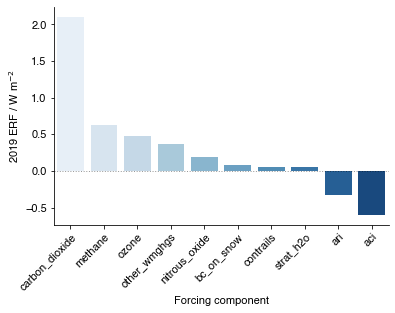

In [90]:
g = sn.barplot(data=default_test['RF'].groupby(RF_categories.to_dict(),axis=1,level=2).sum().loc[[2019]].T.sort_values(ascending=False,by=2019).rename({2019:'2019 ERF / W m$^{-2}$'},axis=1).reset_index(),
               x='Forcing component',
               y='2019 ERF / W m$^{-2}$',
               palette='Blues')

sn.despine()
g.axhline(0,color='k',alpha=0.4,ls=':',lw=1)
g.set_xticklabels(g.get_xticklabels(),rotation=45,ha='right',rotation_mode="anchor")
''

All looks reasonable!

# Appendix I. Linearising Holmes et al. (2013)

Holmes et al. expresses the change in CH4 lifetime with respect to the OH radical as sensitivities, $S$, to a number of factors, $F$:
$$
d\text{ln}(\tau _{\text{CH}_4 \times \text{OH}}) = S \cdot d \text{ln}(F)
$$
Since in FaIRv2.0.0 (at least for the moment), we are only able to model the feedbacks on the *full* lifetime, $\tau$, we need to re-write this in terms of the sensitivity of the *full* lifetime to the factors. Using present-day values for the CH4 lifetime with respect to the non-OH sinks, $x$, we obtain:

$$
a = \sum{\tau_x^{-1}}\\
\tau _{\text{CH}_4 \times \text{OH}} = \frac{\tau}{1-a\tau}
$$
Substituting and expanding about a small perturbation:
$$
\frac{S \Delta F}{F} = \frac{\Delta \tau}{\tau(1-a\tau)}
$$
In FaIRv2.0.0 we instead have:
$$
\tau = \tau_0 e^{r_F F / \tau_0}\\
1 + \frac{\Delta \tau}{\tau} = \text{exp}(r_F \Delta F / \tau_0)
$$

Noting that the FaIRv2.0.0 expression is independent of the absolute value of $F$, unlike the sensitivity form, and expanding about a small perturbation:
$$
r = \frac{S\tau_0 (1-a\tau)}{F}
$$

We could then substitute in present-day values from Holmes et al. to give us a CH4 lifetime form that matches the sensitivity form gradient at the present-day. However, to avoid structural differences between the two forms leading to crazy lifetimes under high-emission scenarios (RCP8.5 I'm looking at you), we instead tune the FaIRv2.0.0 $\Delta \tau$ form to the 2010-2100 lifetime changes under RCP8.5 stated in Holmes et al.. These are:

- Change in $\tau _{\text{CH}_4 \times \text{OH}}$ due to combined water-vapour / temperature sensitivity = 16.6 %
- Change in $\tau _{\text{CH}_4 \times \text{OH}}$ due to CH4 abundance sensitivity = 28.9 %

So we want $1 + \Delta \tau / \tau = \text{exp}(r_F \Delta F / \tau_0)$ to be equal to these same percentage changes. Using the values of $\Delta F$ from Holmes: $\Delta T = 3.8 K$ & $\Delta \text{CH}_4 = 2190$, we obtain ($1-a\tau \sim 0.775$ over this period):

$$
\text{exp}(r_T \cdot 3.8 / \tau_0) = 1 - 0.166 \cdot 0.775\\
\text{exp}(r_A \cdot (2190 / 0.352) / \tau_0) = 1 + 0.289 \cdot 0.775
$$

We can then use these formulas within the historical tuning procedure to obtain $\tau_0$, $r_T$ & $r_A$.